In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import psycopg2
import re

# settings
datapath = '/Users/mirkoknoche/MIMIC/'
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,}'.format
%matplotlib inline

# database
conn_string = open('./intern/DB_connection.txt', 'r', encoding='UTF-8').read()

# Datenbank

In [ ]:
import psycopg2
gitpath = '/Users/mirkoknoche/Google Drive/neuefische/projects/MIMIC/'
conn_string = open(gitpath + 'intern/DB_connection.txt', 'r', encoding='UTF-8').read()
conn = eval('psycopg2.connect({})'.format(conn_string.strip()))

In [ ]:
sql = """select * from vw_t_chartevents LIMIT 1000"""
df_sql = pd.read_sql(sql, conn)

In [ ]:
df_sql.head()

In [ ]:
df_sql.info()

In [ ]:
conn.close()

# inputevents_cv

Inputs are any fluids which have been administered to the patient: such as oral or tube feedings or intravenous solutions containing medications. 

Inputs exist in two separate tables: INPUTEVENTS_CV and INPUTEVENTS_MV. INPUTEVENTS_CV contains CareVue inputs, while INPUTEVENTS_MV contains Metavision inputs. Results from these tables can be unioned as observations are not duplicated across tables. For CareVue data, the rate and volume will be asynchronous, and only the CHARTTIME will be available. For rates, the CHARTTIME will correspond to a start time (when the drug was set to that rate). For volumes, the CHARTTIME will correspond to an end time.

| column | Description | Type |
|:-------|:------------|------|
| ROW_ID | ID from Database | numeric |
| SUBJECT_ID | Unique ID of a patient | numeric |
| HADM_ID | Unique ID of a patient hospital stay | numeric |
| ICUSTAY_ID | Unique ID of a patient ICU stay | numeric |
| CHARTTIME | time at which the measurement was charted at the bedside | datetime |
| ITEMID | Identifier for a single measurement type D_ITEMS.csv | numeric |
| AMOUNT | amount of a drug or substance administered to the patient either between the STARTTIME and ENDTIME | numeric |

In [ ]:
c = 1000000
df_input_cv = pd.read_csv(datapath + 'INPUTEVENTS_CV.csv', nrows=10000)

In [ ]:
sql = """select * from inputevents_cv 
        where subject_id in (select subject_id from diagnoses_icd di where ICD9_CODE = '51881')
        LIMIT 100000"""
df_input_cv = pd.read_sql(sql, conn)

In [ ]:
df_input_cv.shape

In [ ]:
df_input_cv.info()

We can see that already in the first 100000 rows some HADM_ID's are missing. Let us show how many, if we import only this column.

In [ ]:
sql = """select hadm_id from inputevents_cv """
df_test = pd.read_sql(sql, conn)

In [ ]:
df_test.shape

In [ ]:
df_test.isna().sum()

In [ ]:
print('Missing HADM_ID in percent: {:.2f}%'.format(float(df_test.isna().sum()) / df_test.shape[0] *100))

The amount of missing HADM_ID's ist tiny. We ignore these missing entrys.

In [ ]:
df_input_cv.head()

In [ ]:
sql = """select row_id from inputevents_cv """
df_test2 = pd.read_sql(sql, conn)

In [ ]:
df_test2.shape

In [ ]:
df_test2.nunique()

# Find extubations

In [200]:
conn = eval('psycopg2.connect({})'.format(conn_string.strip()))

In [29]:
sql = """select i2.hadm_id, v.* 
        from ventsettings v
        inner join icustays i2 on i2.icustay_id = v.icustay_id 
        where (v.mechvent + v.oxygentherapy + v.extubated + v.selfextubated) > 0
            and i2.hadm_id in (select * from hadm_overview) 
        order by icustay_id, charttime """
df = pd.read_sql(sql, conn)

In [30]:
df.shape

(592571, 7)

In [31]:
df.head(3)

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592571 entries, 0 to 592570
Data columns (total 7 columns):
hadm_id          592571 non-null int64
icustay_id       592571 non-null float64
charttime        592571 non-null datetime64[ns]
mechvent         592571 non-null int64
oxygentherapy    592571 non-null int64
extubated        592571 non-null int64
selfextubated    592571 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 31.6 MB


This dataframe contains all entries from the table chartevents of the selected hadm_id's. We have to find the timestamp of the extubations and we have to check if the first extubation is succesfull.

## Getting the timestamp

Checking the exturbations

In [33]:
df_count_ex = df.groupby('icustay_id').extubated.sum()

In [34]:
df_count_ex.head()

icustay_id
200,006.0    0
200,059.0    0
200,063.0    4
200,065.0    1
200,077.0    0
Name: extubated, dtype: int64

In [35]:
df[(df.extubated == 1)].shape

(4960, 7)

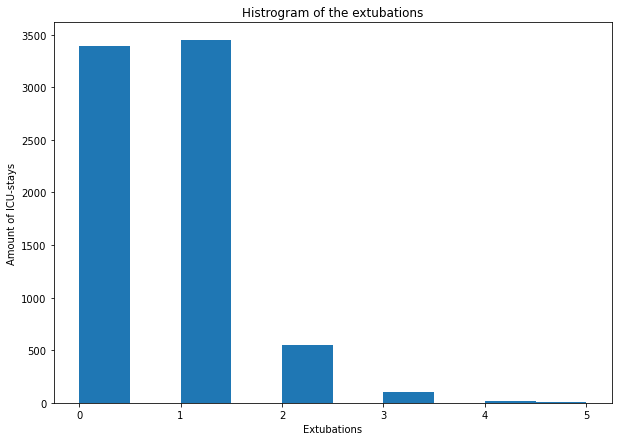

In [36]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_count_ex)
plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Histrogram of the extubations')
plt.savefig('./images/hist_extubations_per_icustay.png')
plt.show();

Many ICU stays have no explicit documented extubation. We need to extract the id's and find another way.

In [37]:
# Building the difference for each row in 'mechvent' to get 
sql = """SELECT i2.hadm_id,
            v.icustay_id,
            v.charttime,
            v.mechvent,
            v.oxygentherapy,
            v.extubated,
            v.selfextubated,
            v.mechvent - lag(v.mechvent, 1) OVER (PARTITION BY v.icustay_id ORDER BY v.icustay_id, v.charttime) AS ex
          FROM ventsettings v
          JOIN icustays i2 ON i2.icustay_id::numeric = v.icustay_id
          WHERE (v.mechvent + v.oxygentherapy + v.extubated + v.selfextubated) > 0 
              AND (i2.hadm_id IN ( SELECT hadm_overview.hadm_id FROM hadm_overview))"""
df_extub = pd.read_sql(sql, conn)

In [38]:
df_extub.shape

(592571, 8)

In [39]:
df_extub.head()

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0,nan
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0,0.0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0,0.0
3,189514,"200,006.0",2159-09-03 23:30:00,1,0,0,0,0.0
4,189514,"200,006.0",2159-09-04 03:50:00,1,0,0,0,0.0


Now we have a new column 'ex'. If the value of 'mechvent' fall from 1 to 0, we get a -1, otherwise we get a +1. Now we can use the timestamp where ex is -1 as our extubation timestamp.

Saving that query as view: `vw_extubations`. <br>
[vw_extubations]('data/04_changes_mechvent.sql)

In [40]:
# Check the new column versus the documented extubations.
sql = """select * 
        from vw_extubations ve
        where ve.icustay_id in (select distinct icustay_id 
                                from vw_extubations ve 
                                where extubated = 1)
            and ve.extubated = 1
            and ve.ex <> -1
        order by ve.icustay_id, ve.charttime"""
df_check_ext1 = pd.read_sql(sql, conn)

In [41]:
df_check_ext1.head(5)

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
0,129142,"200,063.0",2141-03-24 17:30:00,0,0,1,0,0
1,159163,"200,203.0",2140-04-07 13:27:00,0,0,1,0,0
2,142755,"200,240.0",2147-10-28 08:00:00,0,0,1,0,0
3,176395,"200,282.0",2164-05-15 10:05:00,0,0,1,0,0
4,199655,"200,647.0",2116-07-02 11:08:00,0,0,1,0,0


In [ ]:
df_check_ext1.shape

Of 4,960 documented extubations, we cannot determine the expected flag by 1,244 entries as expected. For a better understanding we get a closer look to some single icustay_id.

In [42]:
df_extub[(df.icustay_id == 200203)].sort_values(by='charttime')

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
1162,159163,"200,203.0",2140-04-06 22:00:00,1,0,0,0,nan
1163,159163,"200,203.0",2140-04-07 00:00:00,1,0,0,0,0.0
1164,159163,"200,203.0",2140-04-07 04:00:00,1,0,0,0,0.0
1165,159163,"200,203.0",2140-04-07 04:07:00,1,0,0,0,0.0
1166,159163,"200,203.0",2140-04-07 08:00:00,1,0,0,0,0.0
1167,159163,"200,203.0",2140-04-07 12:00:00,1,0,0,0,0.0
1168,159163,"200,203.0",2140-04-07 13:03:00,0,1,0,0,-1.0
1169,159163,"200,203.0",2140-04-07 13:27:00,0,0,1,0,0.0
1170,159163,"200,203.0",2140-04-07 16:00:00,0,1,0,0,0.0
1171,159163,"200,203.0",2140-04-08 00:00:00,0,1,0,0,0.0


As you can see, the oxygentherapy has been documented here first and then the extubation. Due to the temporal proximity and the presumably dynamic documentation of an intensive care unit, the end of mechanical ventilation is determined as extubation. The time is needed to extract the last data before the extubation from the table chartevents. Therefore, a very precise time is not decisive here.

In [43]:
df_extub[(df.icustay_id == 200006)].sort_values(by='charttime')

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0,nan
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0,0.0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0,0.0
3,189514,"200,006.0",2159-09-03 23:30:00,1,0,0,0,0.0
4,189514,"200,006.0",2159-09-04 03:50:00,1,0,0,0,0.0
5,189514,"200,006.0",2159-09-04 07:00:00,0,1,0,0,-1.0
6,189514,"200,006.0",2159-09-04 11:00:00,0,1,0,0,0.0
7,189514,"200,006.0",2159-09-04 17:00:00,0,1,0,0,0.0


Considering the creation of the table 'vent_settings', which indicates the beginning of oxygen therapy the ventilation has ended, the column 'extubated' is not complete.

In [44]:
# Creating query for extubation timestamps
sql = """select distinct i2.hadm_id, ve.icustay_id, ve.charttime
        from vw_extubations ve 
        inner JOIN icustays i2 ON i2.icustay_id::numeric = ve.icustay_id
        where ve.ex = -1
        group by i2.hadm_id, ve.icustay_id, ve.charttime
        order by ve.icustay_id"""
df_extub_time = pd.read_sql(sql, conn)

In [45]:
df_extub_time.head()

,hadm_id,icustay_id,charttime
0,189514,"200,006.0",2159-09-04 07:00:00
1,199133,"200,059.0",2198-02-17 14:30:00
2,199133,"200,059.0",2198-02-17 19:00:00
3,199133,"200,059.0",2198-02-18 11:15:00
4,199133,"200,059.0",2198-02-19 07:32:00


Some icustay's includes more than one extubation. Saving that query as: `vw_timestamp_extubation`

## Create the label

In order to determine the success of the first extubation, we need its time and, if available, also the first intubation. For the classification we also need the time between ex- and intubation. 

In [49]:
# Calculated the time between extubation and the next possible intubation in hours
# and axtract the first changes of mechanical ventilation
sql = """SELECT first_tube.hadm_id,
            first_tube.icustay_id,
            first_tube.ts_first,
            first_tube.ex,
            date_part('epoch'::text, first_tube.ts_first - lag(first_tube.ts_first, 1) OVER (PARTITION BY first_tube.icustay_id ORDER BY first_tube.ts_first)) / 3600::double precision AS dauer_h
           FROM 
                ( SELECT ve.hadm_id,
                    ve.icustay_id,
                    min(ve.charttime) AS ts_first,	--first timestamp of the change
                    ve.ex
                   FROM vw_extubations ve
                  WHERE ve.ex <> 0
                  GROUP BY ve.hadm_id, ve.icustay_id, ve.ex
                  ORDER BY ve.icustay_id, (min(ve.charttime))) first_tube
          ORDER BY first_tube.icustay_id, first_tube.ts_first"""
df_ex_ts = pd.read_sql(sql, conn)

In [50]:
df_ex_ts.head()

,hadm_id,icustay_id,ts_first,ex,dauer_h
0,189514,"200,006.0",2159-09-04 07:00:00,-1,nan
1,199133,"200,059.0",2198-02-17 14:30:00,-1,nan
2,199133,"200,059.0",2198-02-17 15:00:00,1,0.5
3,129142,"200,063.0",2141-03-15 14:09:00,-1,nan
4,129142,"200,063.0",2141-03-16 09:00:00,1,18.85


In [54]:
# Add the label: 
# duration betwenn in- or extubation is greater then 48h or nan, then 1
# else 1
sql = """SELECT res.hadm_id,
            res.icustay_id,
            res.dauer,
            res.label
           FROM 
                ( SELECT duration.hadm_id,
                    duration.icustay_id,
                    max(duration.dauer_h) AS dauer,
                        CASE
                            WHEN max(duration.dauer_h) IS NULL THEN 1
                            WHEN max(duration.dauer_h) > 48::double precision THEN 1
                            ELSE 0
                        END AS label
                   FROM 
                        ( SELECT first_tube.hadm_id,
                            first_tube.icustay_id,
                            first_tube.ts_first,
                            first_tube.ex,
                            date_part('epoch'::text, first_tube.ts_first - lag(first_tube.ts_first, 1) OVER (PARTITION BY first_tube.icustay_id ORDER BY first_tube.ts_first)) / 3600::double precision AS dauer_h
                           FROM 
                                ( SELECT ve.hadm_id,
                                    ve.icustay_id,
                                    min(ve.charttime) AS ts_first,	--first timestamp of the change
                                    ve.ex
                                   FROM vw_extubations ve
                                  WHERE ve.ex <> 0
                                  GROUP BY ve.hadm_id, ve.icustay_id, ve.ex
                                  ORDER BY ve.icustay_id, (min(ve.charttime))) first_tube
                          ORDER BY first_tube.icustay_id, first_tube.ts_first) duration
                  GROUP BY duration.hadm_id, duration.icustay_id
                  ORDER BY duration.icustay_id) res
          WHERE res.dauer <> 0::double precision OR res.dauer IS NULL"""
df_label_ex = pd.read_sql(sql, conn)

In [62]:
df_label_ex.head()

,hadm_id,icustay_id,dauer,label
0,189514,"200,006.0",nan,1
1,199133,"200,059.0",0.5,0
2,129142,"200,063.0",18.85,0
3,112840,"200,065.0",nan,1
4,113580,"200,077.0",0.5,0


Saving this query as `vw_label_extubations`

In [73]:
df_label_ex[(df_label_ex.dauer > 48)].hadm_id.count()

1015

In [76]:
df_label_ex[(df_label_ex.dauer.isna())].hadm_id.count()

3112

In [77]:
df_label_ex[(df_label_ex.label == 0)].hadm_id.count()

2071

In [55]:
df_label_ex.shape

(6198, 4)

In [59]:
df_label_ex.groupby('label').icustay_id.count()

label
0    2071
1    4127
Name: icustay_id, dtype: int64

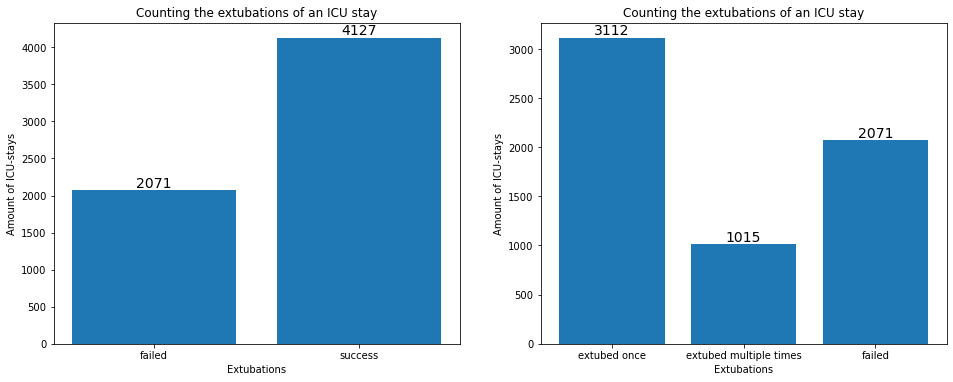

In [102]:
fig = plt.figure(figsize=(16,13))
ax1 = fig.add_subplot(2, 2, 1)
x_val1 = ['failed', 'success']
y_val1 = df_label_ex.groupby('label').icustay_id.count()
ax1.bar(x= x_val1, height=y_val1)
for _, value in enumerate(y_val1):
    plt.text(x_val1[_], value, str(value), fontsize=14,
            horizontalalignment='center', va='bottom')
plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Counting the extubations of an ICU stay')

ax2 = fig.add_subplot(2, 2, 2)
x_val2 = ['extubed once', 'extubed multiple times', 'failed']
y_val2 = [df_label_ex[(df_label_ex.dauer.isna())].hadm_id.count(),
         df_label_ex[(df_label_ex.dauer > 48)].hadm_id.count(),
         df_label_ex[(df_label_ex.label == 0)].hadm_id.count()]
ax2.bar(x= x_val2, height=y_val2)

for _, value in enumerate(y_val2):
    plt.text(x_val2[_], value, str(value), fontsize=14,
            horizontalalignment='center', va='bottom')

plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Counting the extubations of an ICU stay')
plt.savefig('./images/label_extubations.png')
plt.show();

In [56]:
df_label_ex.hadm_id.nunique()

5818

In [57]:
df_label_ex.icustay_id.nunique()

6198

Some patients have been successfully extubated more often during their stay in hospital.

## Unknown

In [ ]:
df.groupby('extubated').count()

In [ ]:
err_ext = list(df_count_ex[df_count_ex == 0].index)

In [ ]:
len(err_ext)

In [ ]:
sql = """select * from transfers"""
df_icuunit = pd.read_sql(sql, conn)

df_icuunit = df_icuunit[df_icuunit.icustay_id.isin(err_ext)]
df_icuunit = df_icuunit[['icustay_id', 'curr_careunit']]
df_icuunit.drop_duplicates(inplace=True)

In [ ]:
df_plot = df_icuunit.groupby('curr_careunit').count()

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.bar(list(df_plot.index), height=list(df_plot.values.flatten()))
plt.ylabel('Missing extubations')
plt.xlabel('ICU units')
plt.title('Not documented extubations')
plt.savefig('./images/missing_extubations_per_unit.png')
plt.show();

In [ ]:
 df_plot

In [ ]:
df_qry = df[df.icustay_id == 200063]

In [ ]:
df_qry.head()

In [ ]:
df_qry['extube'] = df_qry['mechvent'].diff()
# df_qry['extube'] = df_qry['extube'].pow(2)

In [ ]:
df_qry['oxy'] = df_qry['oxygentherapy'].diff()
# df_qry['oxy'] = df_qry['oxy'].pow(2)

In [ ]:
df_qry.extube.fillna(0, inplace=True)
df_qry.oxy.fillna(0, inplace=True)

In [ ]:
df_qry.loc[160:180]

In [ ]:
df_qry[(df_qry['extube'] != 0) | (df_qry['oxy'] != 0)]

**Oxygentherapy** is ventilation without intubation

**Check extubation**

In [ ]:
icustay_ids = df['icustay_id'].unique()
print(len(icustay_ids))

In [ ]:
sql = """select distinct icustay_id 
        from vw_extubations ve 
        where extubated = 1"""
df_icu_ext = pd.read_sql(sql, conn)

In [ ]:
df_icu_ext.shape

In [ ]:
print(f'Documentation of extubations: {df_icu_ext.shape[0] / len(icustay_ids) * 100:.1f} %')

There are 4,123 ICU stays with explicit documentated extubation. And 7,513 ICU stays totally.

In [ ]:
df['extube'] = df['mechvent'].diff()
df.extube.fillna(0, inplace=True)

In [ ]:
df.head()

In [ ]:
df[(df['extube'] < 0) & (~df['icustay_id'].isin(err_ext))].sample(10)

Möglicherweise ist die Beendigung der mechanischen Beatmung ein häufigeres und ebenso genaues Merkmal.We need another marker to get the timestamp of the extubation. 

In [ ]:
df[(df['extubated'] == 1)].groupby('extube').count()

In [ ]:
for i in icustay_ids:
    df[(df['icustay_id'] == i)]['extube'] = df[(df['icustay_id'] == i)].mechvent.diff()

In [ ]:
df.groupby('extube').count()

In [13]:
conn.close()

In [ ]:
df.drop('extube', axis=1, inplace=True)

# Creating the final queries

## Patient_Group

Create the query to get the static features of entries already found in hadm_overview 

In [107]:
sql = """SELECT DISTINCT vle.label,
            ho.hadm_id,
            icu.icustay_id,
            a."SUBJECT_ID",
            p.gender,
            a.admittime,
            p.dob,
                CASE
                    WHEN (date_part('year'::text, a.admittime) - date_part('year'::text, p.dob)) > 89::double precision THEN 90::double precision
                    ELSE date_part('year'::text, a.admittime) - date_part('year'::text, p.dob)
                END AS sub_age,
            last_diagnosis.icd9_code AS last_icd9_code,
            last_diagnosis.amount AS numb_diagn, 
            icu.last_careunit,
            icu.los,
            CASE
                WHEN trach.hadm_id IS NOT NULL THEN 1
                ELSE 0
            END AS tracheo
        FROM hadm_overview ho
        JOIN admissions a ON a.hadm_id = ho.hadm_id
        JOIN patients p ON p.subject_id = a."SUBJECT_ID"
        JOIN ( SELECT di.hadm_id,
                di.icd9_code,
                max_seq.last AS amount
               FROM diagnoses_icd di
                 JOIN ( SELECT di_1.hadm_id,
                        max(di_1.seq_num) AS last
                       FROM diagnoses_icd di_1
                      GROUP BY di_1.hadm_id) max_seq ON max_seq.hadm_id = di.hadm_id AND max_seq.last = di.seq_num) last_diagnosis 
                      ON last_diagnosis.hadm_id = ho.hadm_id
         JOIN ( SELECT DISTINCT i.hadm_id,
                i.icustay_id,
                i.last_careunit,
                i.los
               FROM icustays i
                 LEFT JOIN ( SELECT vte.icustay_id,
                        min(vte.charttime) AS first_extubation
                       FROM vw_timestamp_extubation vte
                      GROUP BY vte.icustay_id) ts ON ts.icustay_id = i.icustay_id::numeric
              WHERE (i.hadm_id IN ( SELECT hadm_overview.hadm_id
                       FROM hadm_overview)) AND ts.first_extubation >= i.intime AND ts.first_extubation <= i.outtime) icu ON icu.hadm_id = ho.hadm_id
        JOIN vw_label_extubations vle ON vle.icustay_id = icu.icustay_id::numeric
        LEFT JOIN ( SELECT d.hadm_id
               FROM drgcodes d
              WHERE d.description::text LIKE '%Tracheostomy%'::text) trach ON ho.hadm_id = trach.hadm_id
        WHERE (ho.hadm_id IN ( SELECT hadm_overview.hadm_id
                   FROM hadm_overview))
        ORDER BY ho.hadm_id, icu.icustay_id"""
df_goal = pd.read_sql(sql, conn)

Saving the query as `vw_patient_group` 

In [108]:
df_goal.shape

(5848, 13)

In [109]:
df_goal.to_csv('data/patient_group.csv', encoding='UTF-8', index=False)

## Events from labevents

In [110]:
sql = """SELECT l.hadm_id,
    last_val.icustay_id,
    l.itemid,
    l.value,
    last_val.ts,
        CASE
            WHEN l.itemid = 50821 THEN 'Pa02'::text
            WHEN l.itemid = 50802 THEN 'base_excess'::text
            WHEN l.itemid = 50820 THEN 'pH'::text
            WHEN l.itemid = 51222 THEN 'hb'::text
            WHEN l.itemid = 51221 THEN 'hct'::text
            WHEN l.itemid = 50912 THEN 'creatinin'::text
            ELSE NULL::text
        END AS item
   FROM labevents l
     JOIN ( SELECT last_events.hadm_id,
            last_events.icustay_id,
            last_events.itemid,
            max(last_events.charttime) AS ts
           FROM ( SELECT l2.hadm_id,
                    l2.itemid,
                    min_ts.icustay_id,
                    l2.charttime,
                    l2.value
                   FROM labevents l2
                   JOIN ( SELECT vte.hadm_id,
                            vte.icustay_id,
                            min(vte.charttime) AS ext_ts
                           FROM vw_timestamp_extubation vte
                          GROUP BY vte.hadm_id, vte.icustay_id) min_ts ON min_ts.hadm_id = l2.hadm_id AND min_ts.ext_ts > l2.charttime
                  WHERE l2.itemid = ANY (ARRAY[50821, 50802, 50820, 51222, 51221, 50912])) last_events
          GROUP BY last_events.hadm_id, last_events.icustay_id, last_events.itemid) last_val ON last_val.hadm_id = l.hadm_id AND last_val.itemid = l.itemid AND last_val.ts = l.charttime
  ORDER BY l.hadm_id, last_val.icustay_id, l.itemid"""

df_lab = pd.read_sql(sql, conn)

In [112]:
df_lab.head(13)

,hadm_id,icustay_id,itemid,value,ts,item
0,100016,"217,590.0",50802,2,2188-05-24 17:24:00,base_excess
1,100016,"217,590.0",50820,7.43,2188-05-24 17:24:00,pH
2,100016,"217,590.0",50821,86,2188-05-24 17:24:00,Pa02
3,100016,"217,590.0",50912,1.1,2188-05-28 04:16:00,creatinin
4,100016,"217,590.0",51221,31.1,2188-05-28 04:16:00,hct
5,100016,"217,590.0",51222,10.3,2188-05-28 04:16:00,hb
6,100017,"258,320.0",50802,4,2103-03-11 05:10:00,base_excess
7,100017,"258,320.0",50820,7.52,2103-03-11 05:10:00,pH
8,100017,"258,320.0",50821,171,2103-03-11 05:10:00,Pa02
9,100017,"258,320.0",50912,0.8,2103-03-11 03:05:00,creatinin


In [113]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35188 entries, 0 to 35187
Data columns (total 6 columns):
hadm_id       35188 non-null int64
icustay_id    35188 non-null float64
itemid        35188 non-null int64
value         35188 non-null object
ts            35188 non-null datetime64[ns]
item          35188 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.6+ MB


In [114]:
df_lab.to_csv('data/labevents_pre_extub.csv', encoding='UTF-8', index=False)

## Events from chartevents

Shrink the size of chartevents and an item-name as additioal information. 

In [ ]:
sql = """SELECT c.hadm_id, c.icustay_id, c.itemid, c.charttime,
            c.value, c.valuenum, c.valueuom,
            case 
                when c.itemid in (211, 220045) then 'hr' 
                when c.itemid in (52, 456, 225312, 220181, 220052) then 'blood_pr'
                when c.itemid in (676,  677, 223762) then 'temp'
                when c.itemid in (646, 834, 220277, 220227) then 'SaO2'
                when c.itemid in (618 ,  220210 , 224688) then 'resp_rat'
                when c.itemid in (445, 448, 449, 224687, 1340, 1486, 1600) then 'breath_min_vol'
                when c.itemid in (189, 190, 3420, 3422, 223835) then 'FiO2'
                when c.itemid in (681, 682, 683, 684, 224685, 224684, 224686) then 'tidal_vol'
                when c.itemid in (444, 224697) then 'mean_insp_pressure'
                when c.itemid in (506, 220339) then 'PEEP'
                when c.itemid in (1127, 861, 1542, 220546) then 'leuko'
                when c.itemid in (225668, 1531, 818) then 'lactic_acid'
            end as item,
            c.storetime, c.cgid, c.warning , c.error , c.resultstatus , c.stopped 
           FROM chartevents c
          WHERE (c.hadm_id IN (SELECT hadm_overview.hadm_id FROM hadm_overview))
            and c.itemid in (211, 220045,
                            52, 456, 225312, 220181, 220052,
                            676,  677, 223762,
                            646, 834, 220277, 220227,
                            618 ,  220210 , 224688,
                            445, 448, 449, 224687, 1340, 1486, 1600,
                            189, 190, 3420, 3422, 223835,
                            681, 682, 683, 684, 224685, 224684, 224686,
                            444, 224697,
                            506, 220339,
                            1127, 861, 1542, 220546,
                            225668, 1531, 818)"""
df_ce_1 = pd.read_sql(sql, conn)

In [ ]:
df_ce_1.head(10)

Save this query as view `vw_ce_filtered` 

Only entries before extubation je icustay_id are of interest for us, so that the entries are filtered out afterwards.

In [ ]:
sql = """select ce.*
            from vw_ce_filtered ce
            inner join (select hadm_id, icustay_id, min(charttime) as ext_ts
                        from vw_timestamp_extubation vte
                        group by hadm_id, icustay_id) min_ts 
                on (min_ts.icustay_id = ce.icustay_id and min_ts.ext_ts > ce.charttime)
            order by ce.icustay_id, ce.charttime desc"""
df_ce_2 = pd.read_sql(sql, conn)

In [ ]:
df_ce_2.head(10)

From the entries before extubation, we needed for each item the entry that is closest to extubation. Since in a grouping the column value would destroy the grouping, we grab only the columns icustay_id, charttime and item and then connect this result to the view vw_ce_filtered to get the value.

In [201]:
sql = """select ce.icustay_id, ce.item, max(ce.charttime) as last_ts
            from vw_ce_filtered ce
            inner join (select hadm_id, icustay_id, min(charttime) as ext_ts
                        from vw_timestamp_extubation vte
                        group by hadm_id, icustay_id) min_ts 
                on (min_ts.icustay_id = ce.icustay_id and min_ts.ext_ts > ce.charttime)
            where ce.icustay_id in (245719, 217590)
            group by ce.icustay_id, ce.item 
            order by ce.icustay_id, ce.item"""
df_ce_3 = pd.read_sql(sql, conn)

In [203]:
df_ce_3.head(13)

,icustay_id,item,last_ts
0,"217,590.0",blood_pr,2188-05-28 08:00:00
1,"217,590.0",breath_min_vol,2188-05-28 08:00:00
2,"217,590.0",FiO2,2188-05-28 08:00:00
3,"217,590.0",hr,2188-05-28 08:00:00
4,"217,590.0",leuko,2188-05-28 05:16:00
5,"217,590.0",mean_insp_pressure,2188-05-28 08:00:00
6,"217,590.0",PEEP,2188-05-28 08:00:00
7,"217,590.0",resp_rat,2188-05-28 08:00:00
8,"217,590.0",SaO2,2188-05-28 08:00:00
9,"217,590.0",tidal_vol,2188-05-28 08:00:00


From the df_ce_3 result the value matching icustay_id, item and last_ts must now be determined.

In [23]:
sql = """select distinct vcf.* 
        from vw_ce_filtered vcf 
        inner join (select distinct ce.icustay_id, ce.item, max(ce.charttime) as last_ts
                    from vw_ce_filtered ce
                    inner join (select hadm_id, icustay_id, min(charttime) as ext_ts
                                from vw_timestamp_extubation vte
                                group by hadm_id, icustay_id) min_ts 
                        on (min_ts.icustay_id = ce.icustay_id and min_ts.ext_ts > ce.charttime)
                    group by ce.icustay_id, ce.item) last_events
            on (last_events.icustay_id = vcf.icustay_id and last_events.item = vcf.item and last_events.last_ts = vcf.charttime)
        order by vcf.hadm_id , vcf.icustay_id"""
df_ce = pd.read_sql(sql, conn)

In [24]:
df_ce.head()

,hadm_id,icustay_id,itemid,charttime,value,valuenum,valueuom,item,storetime,cgid,warning,error,resultstatus,stopped
0,"100,016.0","217,590.0","220,045.0",2188-05-28 08:00:00,91,91.0,bpm,hr,2188-05-28 08:02:00,"15,623.0",0.0,0.0,None,None
1,"100,016.0","217,590.0","220,181.0",2188-05-28 08:00:00,88,88.0,mmHg,blood_pr,2188-05-28 08:02:00,"15,623.0",0.0,0.0,None,None
2,"100,016.0","217,590.0","220,210.0",2188-05-28 08:00:00,18,18.0,insp/min,resp_rat,2188-05-28 08:02:00,"15,623.0",0.0,0.0,None,None
3,"100,016.0","217,590.0","220,277.0",2188-05-28 08:00:00,100,100.0,%,SaO2,2188-05-28 08:02:00,"15,623.0",0.0,0.0,None,None
4,"100,016.0","217,590.0","220,339.0",2188-05-28 08:00:00,5,5.0,cmH2O,PEEP,2188-05-28 07:36:00,"20,803.0",0.0,0.0,None,None


In [25]:
df_ce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74306 entries, 0 to 74305
Data columns (total 14 columns):
hadm_id         74306 non-null float64
icustay_id      74306 non-null float64
itemid          74306 non-null float64
charttime       74306 non-null datetime64[ns]
value           73903 non-null object
valuenum        73992 non-null float64
valueuom        59637 non-null object
item            74306 non-null object
storetime       74220 non-null datetime64[ns]
cgid            74220 non-null float64
warning         33854 non-null float64
error           33854 non-null float64
resultstatus    11633 non-null object
stopped         40377 non-null object
dtypes: datetime64[ns](2), float64(7), object(5)
memory usage: 7.9+ MB


So that the result can be retrieved quickly and repeatedly in the future, we create a new table with the name chartev_values.

In [26]:
df_ce.to_csv('data/chartevents_pre_extub.csv', encoding='UTF-8', index=False)

In [204]:
conn.close()